<a href="https://colab.research.google.com/github/Ankixz/Cotton_Plant_Disease_Detection_using_dl_and_drone/blob/main/Efficient_net_B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Set paths
project_path = "/content/drive/MyDrive/cotton_project"
os.makedirs(project_path, exist_ok=True)

model_path = f"{project_path}/best_finetuned.pth"
history_path = f"{project_path}/training_history.pt"


Mounted at /content/drive


In [ ]:
import os, shutil
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import random_split

# ✅ Set your raw dataset and save path
raw_path = "/content/drive/MyDrive/Dataset_Trial1"
split_base = "/content/drive/MyDrive/cotton_project/cotton_split"
os.makedirs(split_base, exist_ok=True)

# Define image transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load entire dataset
dataset = ImageFolder(root=raw_path, transform=transform)
class_names = dataset.classes

# Split into 70/15/15
total_len = len(dataset)
train_len = int(0.7 * total_len)
val_len = int(0.15 * total_len)
test_len = total_len - train_len - val_len
train_data, val_data, test_data = random_split(dataset, [train_len, val_len, test_len])

# Function to save split images to folders
def save_split(split_data, split_name):
    split_dir = os.path.join(split_base, split_name)
    os.makedirs(split_dir, exist_ok=True)
    for i, (img, label) in enumerate(split_data):
        class_name = class_names[label]
        class_dir = os.path.join(split_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)
        img_pil = transforms.ToPILImage()(img)
        img_pil.save(os.path.join(class_dir, f"{split_name}_{i}.jpg"))

# Save all splits
save_split(train_data, "train")
save_split(val_data, "val")
save_split(test_data, "test")

print("✅ Dataset split complete!")
print("📁 Saved to:", split_base)


✅ Dataset split complete!
📁 Saved to: /content/drive/MyDrive/cotton_project/cotton_split


In [ ]:
import torch
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
import os

# Set the path to the split dataset on Drive
split_base = "/content/drive/MyDrive/cotton_project/cotton_split"

# Define image transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load datasets
train_dataset = ImageFolder(root=os.path.join(split_base, "train"), transform=transform)
val_dataset   = ImageFolder(root=os.path.join(split_base, "val"), transform=transform)
test_dataset  = ImageFolder(root=os.path.join(split_base, "test"), transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Get class names
class_names = train_dataset.classes
print("✅ Dataloaders created. Classes:", class_names)


✅ Dataloaders created. Classes: ['Aphids', 'Army worm', 'Bacterial Blight', 'Cotton Boll Rot', 'Curl Virus', 'Fussarium Wilt', 'Green Cotton Boll', 'Healthy', 'Powdery mildew', 'Target Spot']


In [ ]:
import timm
import torch.nn as nn

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define model
num_classes = len(class_names)
model = timm.create_model("tf_efficientnet_b0", pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, num_classes)
model = model.to(device)

# Save initial model structure with classifier head
model_head_path = "/content/drive/MyDrive/cotton_project/baseline_classifier_head.pth"
torch.save(model.state_dict(), model_head_path)

print("✅ Model initialized and classifier head saved to Drive.")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

✅ Model initialized and classifier head saved to Drive.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import os

# Reload the saved model (if restarting runtime)
model_path = "/content/drive/MyDrive/cotton_project/baseline_classifier_head.pth"
model.load_state_dict(torch.load(model_path))
for param in model.parameters():
    param.requires_grad = True

# Optimizer & loss
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

# For saving the best model and history
best_model_path = "/content/drive/MyDrive/cotton_project/best_finetuned.pth"
history_path = "/content/drive/MyDrive/cotton_project/training_history.pt"

# Training config
num_epochs = 5
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'lr': []}
best_val_loss = float('inf')

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss, correct, total = 0.0, 0, 0
    history['lr'].append(optimizer.param_groups[0]['lr'])

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    train_loss /= len(train_loader.dataset)
    train_acc = correct / total
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader.dataset)
    val_acc = correct / total
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch+1}: "
          f"Train Loss={train_loss:.4f}, Acc={train_acc:.4f} | "
          f"Val Loss={val_loss:.4f}, Acc={val_acc:.4f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print("  → ✅ Saved best fine-tuned model.")

# Save training history
torch.save(history, history_path)
print("✅ Training complete. Model and history saved to Drive.")


Epoch 1 [Val]: 100%|██████████| 39/39 [00:59<00:00,  1.52s/it]


Epoch 1: Train Loss=1.0634, Acc=0.7801 | Val Loss=0.1700, Acc=0.9679
  → ✅ Saved best fine-tuned model.


Epoch 2 [Val]: 100%|██████████| 39/39 [01:00<00:00,  1.54s/it]


Epoch 2: Train Loss=0.1266, Acc=0.9717 | Val Loss=0.0438, Acc=0.9904
  → ✅ Saved best fine-tuned model.


Epoch 3 [Val]: 100%|██████████| 39/39 [01:01<00:00,  1.59s/it]


Epoch 3: Train Loss=0.0506, Acc=0.9900 | Val Loss=0.0430, Acc=0.9856
  → ✅ Saved best fine-tuned model.


Epoch 4 [Val]: 100%|██████████| 39/39 [00:59<00:00,  1.52s/it]


Epoch 4: Train Loss=0.0306, Acc=0.9924 | Val Loss=0.0280, Acc=0.9936
  → ✅ Saved best fine-tuned model.


Epoch 5 [Val]: 100%|██████████| 39/39 [00:59<00:00,  1.53s/it]


Epoch 5: Train Loss=0.0189, Acc=0.9959 | Val Loss=0.0272, Acc=0.9928
  → ✅ Saved best fine-tuned model.
✅ Training complete. Model and history saved to Drive.


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Load best model
model.load_state_dict(torch.load("/content/drive/MyDrive/cotton_project/best_finetuned.pth"))
model.eval()

all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        preds = probs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

print("✅ Predictions collected from test set.")


✅ Predictions collected from test set.


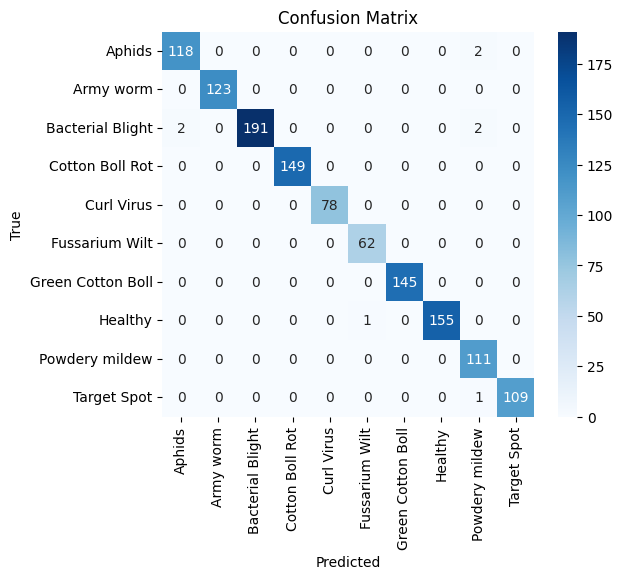

Classification Report:

                   precision    recall  f1-score   support

           Aphids     0.9833    0.9833    0.9833       120
        Army worm     1.0000    1.0000    1.0000       123
 Bacterial Blight     1.0000    0.9795    0.9896       195
  Cotton Boll Rot     1.0000    1.0000    1.0000       149
       Curl Virus     1.0000    1.0000    1.0000        78
   Fussarium Wilt     0.9841    1.0000    0.9920        62
Green Cotton Boll     1.0000    1.0000    1.0000       145
          Healthy     1.0000    0.9936    0.9968       156
   Powdery mildew     0.9569    1.0000    0.9780       111
      Target Spot     1.0000    0.9909    0.9954       110

         accuracy                         0.9936      1249
        macro avg     0.9924    0.9947    0.9935      1249
     weighted avg     0.9938    0.9936    0.9936      1249



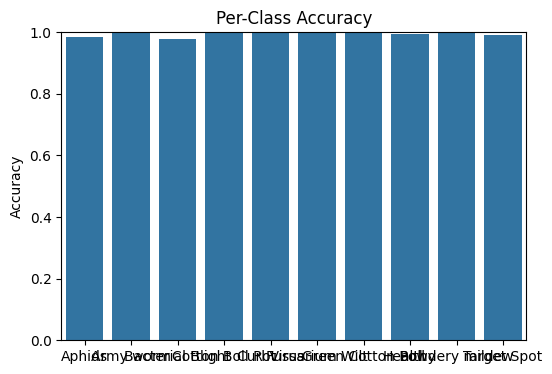

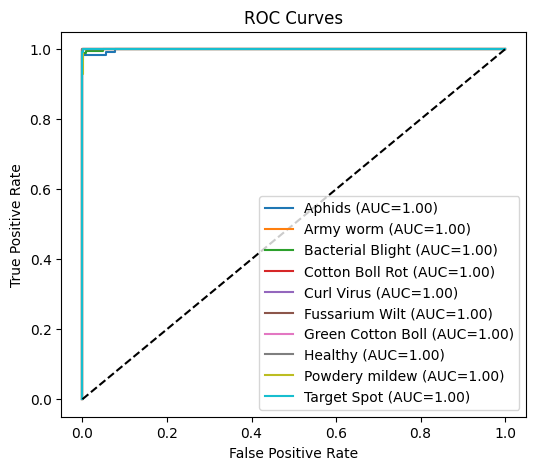

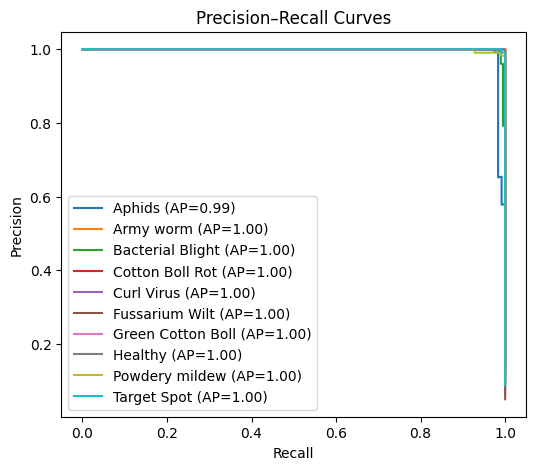

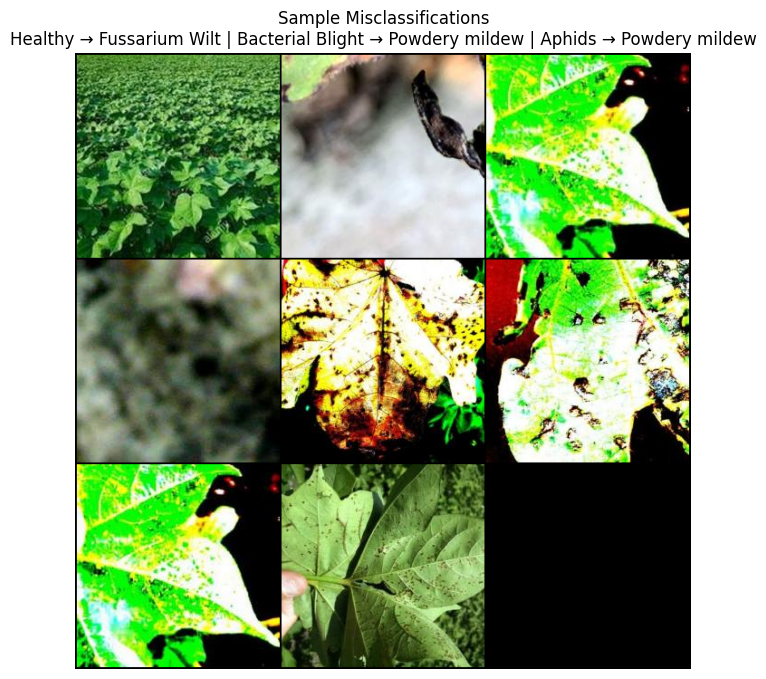

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


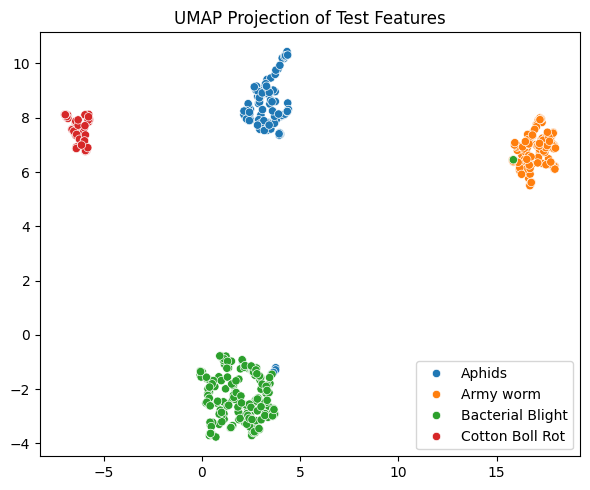

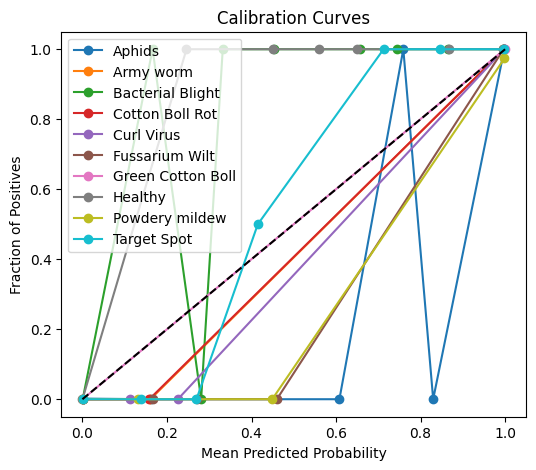

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, auc,
    precision_recall_curve, average_precision_score
)
from sklearn.calibration import calibration_curve
from torchvision.utils import make_grid
from umap import UMAP
import random

# Define class names if needed
# class_names = test_dataset.classes  # Already defined

# 1. Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 2. Classification Report
print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

# 3. Per-Class Accuracy
per_class_acc = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(6,4))
sns.barplot(x=class_names, y=per_class_acc)
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Per-Class Accuracy")
plt.show()

# 4. ROC Curves
plt.figure(figsize=(6,5))
for i, cls in enumerate(class_names):
    fpr, tpr, _ = roc_curve((np.array(all_labels) == i), all_probs[:, i])
    plt.plot(fpr, tpr, label=f"{cls} (AUC={auc(fpr,tpr):.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()

# 5. Precision–Recall Curves
plt.figure(figsize=(6,5))
for i, cls in enumerate(class_names):
    precision, recall, _ = precision_recall_curve((np.array(all_labels) == i), all_probs[:, i])
    ap = average_precision_score((np.array(all_labels) == i), all_probs[:, i])
    plt.plot(recall, precision, label=f"{cls} (AP={ap:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves")
plt.legend()
plt.show()

# 6. Sample Misclassifications
misclassified_indices = np.where(all_preds != all_labels)[0]
sample_mis = random.sample(list(misclassified_indices), min(9, len(misclassified_indices)))
images_to_show = []
titles = []

for idx in sample_mis:
    img, true_label = test_dataset[idx]
    pred_label = all_preds[idx]
    images_to_show.append(img)
    titles.append(f"{class_names[true_label]} → {class_names[pred_label]}")

grid = make_grid(images_to_show, nrow=3, normalize=True, scale_each=True)
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0))
plt.axis("off")
plt.title("Sample Misclassifications\n" + " | ".join(titles[:3]))
plt.show()

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from umap import UMAP
import torch

# ✅ Extract features from the model and flatten them
def extract_features(model, dataloader, n_samples=500):
    features, labels = [], []
    model.eval()
    with torch.no_grad():
        for images, lbls in dataloader:
            images = images.to(device)
            # Get intermediate feature maps
            f = model.forward_features(images)
            # Global average pooling to convert [B, C, H, W] → [B, C]
            if f.ndim == 4:
                f = torch.nn.functional.adaptive_avg_pool2d(f, (1, 1)).squeeze(-1).squeeze(-1)
            features.append(f.cpu().numpy())
            labels.append(lbls.numpy())
            if sum(len(x) for x in features) >= n_samples:
                break
    features = np.vstack(features)[:n_samples]
    labels = np.concatenate(labels)[:n_samples]
    return features, labels

# ✅ Apply UMAP
features, labels_umap = extract_features(model, test_loader, n_samples=500)
embedding = UMAP(n_components=2).fit_transform(features)

# ✅ Plot the UMAP scatter plot
plt.figure(figsize=(6, 5))
sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=[class_names[i] for i in labels_umap],
    palette="tab10"
)
plt.title("UMAP Projection of Test Features")
plt.legend()
plt.tight_layout()
plt.show()

# 8. Calibration Curves
plt.figure(figsize=(6,5))
for i, cls in enumerate(class_names):
    prob_true, prob_pred = calibration_curve((np.array(all_labels) == i), all_probs[:, i], n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=cls)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curves")
plt.legend()
plt.show()


In [ ]:
# Cell 10: Get Class Names from your EfficientNet Dataset

import os
from torchvision.datasets import ImageFolder
from torchvision import transforms

# Set your raw dataset path (or the split_base path if you prefer to confirm from there)
# Use the same path as you used when you defined `dataset = ImageFolder(root=raw_path, transform=transform)`
raw_path = "/content/drive/MyDrive/Dataset_Trial1" # Or "/content/drive/MyDrive/cotton_project/cotton_split/train"

# Define a minimal transform just to load the dataset
transform = transforms.Compose([transforms.ToTensor()])

# Load the dataset (or a subset like train_dataset) to get class names
dataset_for_class_names = ImageFolder(root=raw_path, transform=transform) # Use raw_path or split_base/train
class_names_from_dataset = dataset_for_class_names.classes

print("EfficientNet Class Names (in order):", class_names_from_dataset)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Dataset_Trial1'

In [ ]:
# Load datasets
train_dataset = ImageFolder(root=os.path.join(split_base, "train"), transform=transform)
val_dataset   = ImageFolder(root=os.path.join(split_base, "val"), transform=transform)
test_dataset  = ImageFolder(root=os.path.join(split_base, "test"), transform=transform)

# Get class names
class_names = train_dataset.classes
print("✅ Dataloaders created. Classes:", class_names)

NameError: name 'split_base' is not defined